# ~~Splashing Lionesses~~
# Thrashing Lions 

## 105 vehicles had an odometer change greater than 200,000 miles : due to bad data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timezone
import time 
start_time = time.time()

In [2]:
df_fuel_trans = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv')
df_truck_info = pd.read_csv('data/IBGEFILE.UNITS.csv')
df_fuel_opt = pd.read_csv('data/BGEIDSC.EF2EFFP.csv')
df_level = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv')
df_events = pd.read_csv('data/Extranet2.ExactFuelEvents.csv')
df_events['EventTimeStamp'] = pd.to_datetime(df_events['EventTimeStamp'])
df_performance = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv')
df_events = df_events.drop(columns=['EquipmentType']) ## - 1 unique entry
df_event_level = pd.merge(df_events, df_level, how='left', left_on='ESS_Id', right_on='ExactFuelEventId')

In [3]:
df_truck_info.UNMAKE.value_counts()

KENWORTH        524
VOLVO           139
FREIGHTLINER     15
PETERBILT        14
MACK             10
                  4
SYSTEM TEST       1
KEWORTH           1
KENOWRTH          1
Name: UNMAKE, dtype: int64

In [4]:
df_truck_info['UNMAKE'] = df_truck_info.UNMAKE.str.replace('KENOWRTH','KENWORTH')
df_truck_info['UNMAKE'] = df_truck_info.UNMAKE.str.replace('KEWORTH','KENWORTH')
df_truck_info['UNMAKE'] = df_truck_info['UNMAKE'].str.strip()
df_truck_info = df_truck_info[~df_truck_info['UNMAKE'].isin(['SYSTEM TEST',''])]
df_truck_info.UNMAKE.value_counts()

KENWORTH        526
VOLVO           139
FREIGHTLINER     15
PETERBILT        14
MACK             10
Name: UNMAKE, dtype: int64

In [5]:
df_truck_info.head()

,UNUNIT,UNYEAR,UNMAKE
0,535,1996,PETERBILT
1,534,1996,PETERBILT
2,533,1996,PETERBILT
3,532,1996,PETERBILT
4,531,1996,PETERBILT


In [6]:
# NEED TO CONVERT  df_fuel_trans.TRNUNT  and EquipmentID to same dtype
df_fuel_trans['TRNUNT'] = df_fuel_trans['TRNUNT'].apply(str)
df_events['EquipmentID'] = df_events['EquipmentID'].apply(str)

df_fuel_trans['TRNUNT'] = df_fuel_trans['TRNUNT'].str.strip()
df_events['EquipmentID'] = df_events['EquipmentID'].str.strip()

print(df_fuel_trans['TRNUNT'].dtype)
print(df_events['EquipmentID'].dtype)

object
object


In [7]:
fuels = ['ULSD', 'FUEL', 'CDSL', 'DEFC', 'DSL1', 'BDSL']

In [8]:
###### REMOVING ODOMETER READING OF 0 #######
df_events_no_blank_odo = df_events[~(df_events[['Odometer']] == 0).any(axis=1)]

truck_events = df_events_no_blank_odo.EquipmentID.value_counts().sort_values(ascending=False)
truck_events = pd.DataFrame(data=truck_events)
truck_events = truck_events.reset_index();
truck_events.columns = ['EquipmentID','Count']

In [9]:
miles_by_truck = pd.DataFrame()
miles_by_truck['min_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].min()
miles_by_truck['max_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].max()
miles_by_truck['mean_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].mean()
miles_by_truck['median_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].median()
miles_by_truck['min_mean_variance'] = miles_by_truck['max_odo']-miles_by_truck['mean_odo']
miles_by_truck['max_mean_variance'] = miles_by_truck['mean_odo']-miles_by_truck['min_odo']
miles_by_truck['variance_of_variances'] = miles_by_truck['max_mean_variance']-miles_by_truck['min_mean_variance']
miles_by_truck['odo_change'] = (miles_by_truck['max_odo'] - miles_by_truck['min_odo'])
miles_by_truck = miles_by_truck.reset_index()
miles_by_truck = miles_by_truck[miles_by_truck['odo_change'] > 5000] 
miles_by_truck['EquipmentID'] = miles_by_truck['EquipmentID'].apply(str)

In [10]:
df_events = pd.merge(left=df_events, right=miles_by_truck, how='left', left_on='EquipmentID', right_on='EquipmentID')

In [11]:
df_events['odo_from_median_pct'] = (df_events.Odometer/df_events.median_odo)
df_events['odo_from_median_num'] = (df_events.Odometer-df_events.median_odo)


In [12]:
(df_events[['EquipmentID','Odometer','median_odo','odo_from_median_pct','odo_from_median_num']]).head()

,EquipmentID,Odometer,median_odo,odo_from_median_pct,odo_from_median_num
0,1992,39895.5,115746.2,0.344681,-75850.7
1,1712,360378.8,428578.9,0.840869,-68200.1
2,1713,377577.4,452903.2,0.833682,-75325.8
3,1585,513931.8,545005.3,0.942985,-31073.5
4,1564,498691.0,515350.2,0.967674,-16659.2


In [13]:
df_events_no_nan = df_events.dropna(thresh=5) 
df_events_no_nan.shape

(8495130, 24)

# removing outliers

In [14]:
df_events_no_nan = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.odo_from_median_num < -100000)].index)
df_events_no_nan = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.odo_from_median_num > 100000)].index)
#df_events_no_nan = (df_events_no_nan[df_events_no_nan['odo_from_median_num'] > -100000]) & (df_events_no_nan[df_events_no_nan['odo_from_median_num'] < 100000])

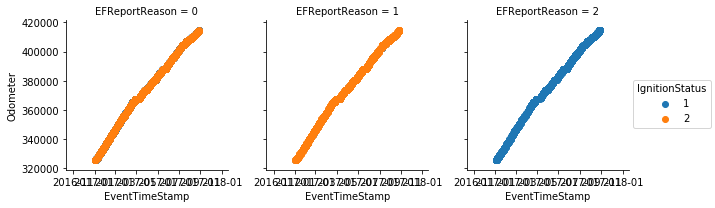

In [15]:
#df_events_no_nan.head()
truck_1762 = df_events_no_nan.loc[(df_events_no_nan['EquipmentID'] == '1762')] 
fg = sns.FacetGrid(data=truck_1762, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend();

In [16]:
miles_by_truck = pd.DataFrame()
miles_by_truck['min_odo'] = df_events_no_nan.groupby(['EquipmentID'])['Odometer'].min()
miles_by_truck['max_odo'] = df_events_no_nan.groupby(['EquipmentID'])['Odometer'].max()
miles_by_truck['median_odo'] = df_events_no_nan.groupby(['EquipmentID'])['Odometer'].median()
miles_by_truck['odo_change'] = (miles_by_truck['max_odo'] - miles_by_truck['min_odo'])
miles_by_truck = miles_by_truck.reset_index()
miles_by_truck = miles_by_truck[miles_by_truck['odo_change'] > 5000] 
miles_by_truck['EquipmentID'] = miles_by_truck['EquipmentID'].apply(str)

In [17]:
# lowest diff range from (302k) - (542k)
# highest diff range from 
#df_events_no_nan[df_events_no_nan['EquipmentID'] == '1554'].sort_values('odo_from_median_num')
#df_events_no_nan[df_events_no_nan['odo_from_median_num'] < -100000]
#odo_no_outliers = df_events_no_nan[(df_events_no_nan.odo_from_median_pct > 0.45) & (df_events_no_nan.odo_from_median_pct < 1.5)]

#df_events_no_nan.shape

# NEED TO DROP NAN FROM MEDIAN_PCT

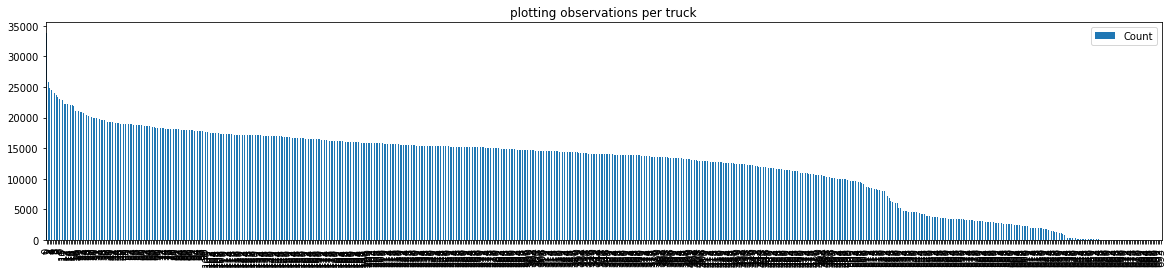

In [18]:
truck_events.plot(kind='bar', figsize=(20,4), title='plotting observations per truck');

# outlier in odometer identified #
# consider outlier identification, delta between MEAN and MEDIAN ?

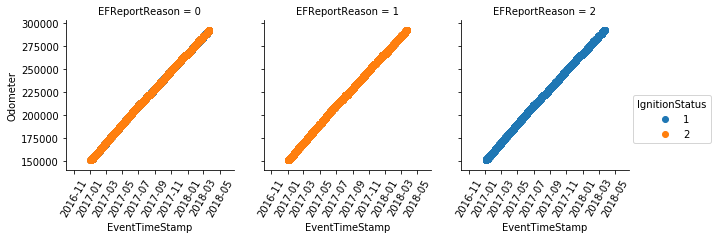

In [19]:
# outlier in odometer identified #
truck_307 = df_event_level.loc[(df_event_level['EquipmentID'] == 307)] 
fg = sns.FacetGrid(data=truck_307, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend();
fg.set_xticklabels(rotation=60)

# expected linear odometer plot #

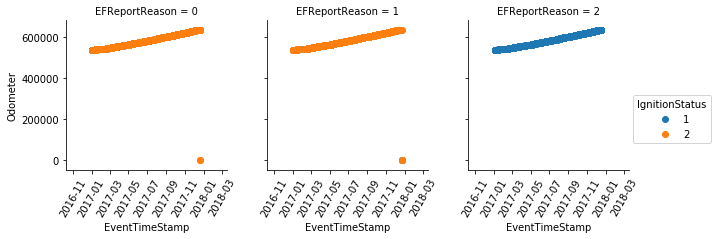

In [75]:
# outlier in odometer identified #
truck_1601 = df_event_level.loc[(df_event_level['EquipmentID'] == 1601)] 
fg = sns.FacetGrid(data=truck_1601, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

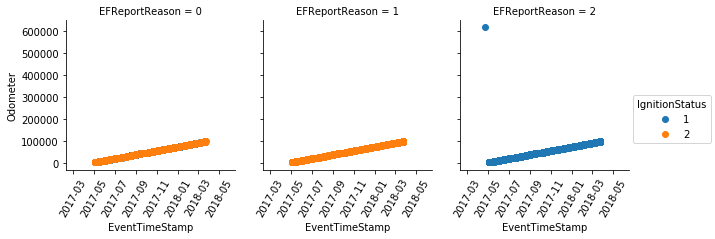

In [76]:
truck_2061 = df_event_level.loc[(df_event_level['EquipmentID'] == 2061)] 
fg = sns.FacetGrid(data=truck_2061, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

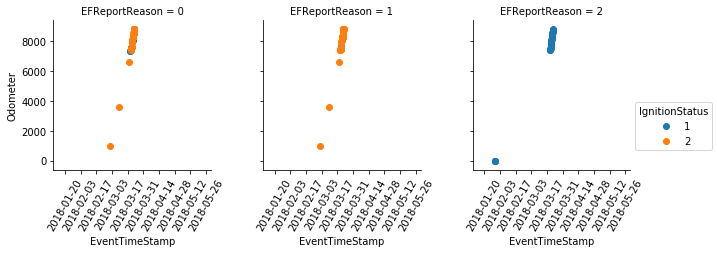

In [77]:
truck_2152 = df_event_level.loc[(df_event_level['EquipmentID'] == 2152)] 
fg = sns.FacetGrid(data=truck_2152, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

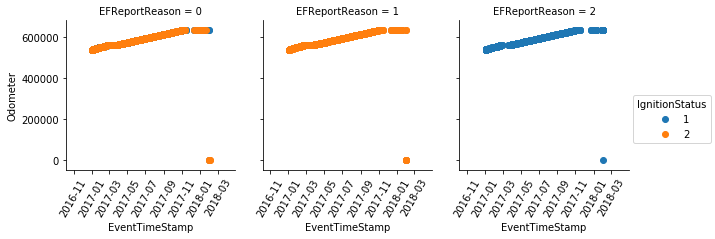

In [78]:
truck_1607 = df_event_level.loc[(df_event_level['EquipmentID'] == 1607)] 
fg = sns.FacetGrid(data=truck_1607, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

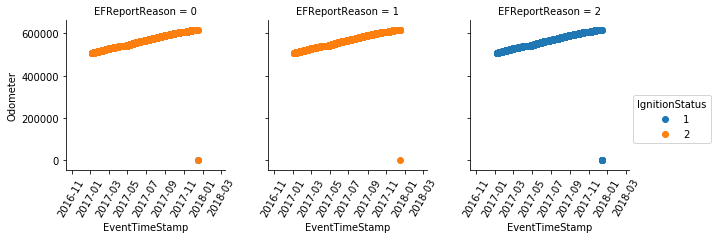

In [79]:
truck_1597 = df_event_level.loc[(df_event_level['EquipmentID'] == 1597)] 
fg = sns.FacetGrid(data=truck_1597, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

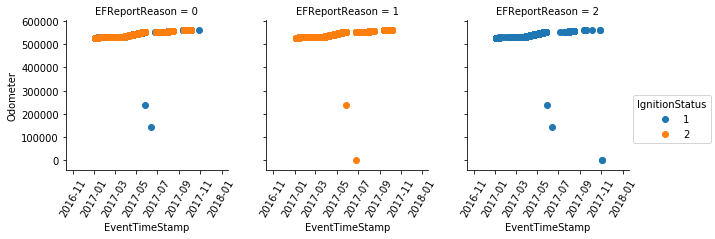

In [80]:
truck_1554 = df_event_level.loc[(df_event_level['EquipmentID'] == 1554)] 
fg = sns.FacetGrid(data=truck_1554, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

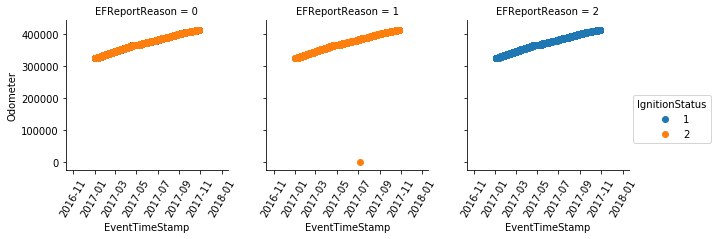

In [81]:
truck_1762 = df_event_level.loc[(df_event_level['EquipmentID'] == 1762)] 
fg = sns.FacetGrid(data=truck_1762, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

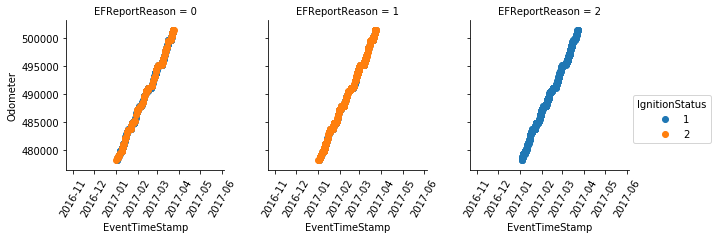

In [82]:
truck_1534 = df_event_level.loc[(df_event_level['EquipmentID'] == 1534)] 
fg = sns.FacetGrid(data=truck_1534, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

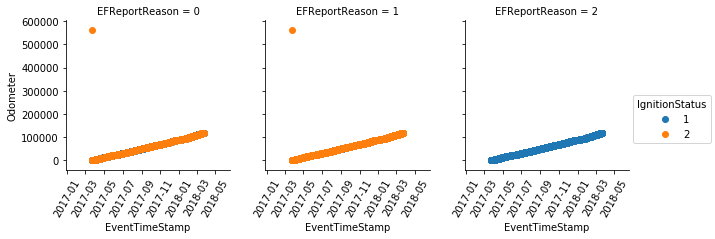

In [83]:
truck_2034 = df_event_level.loc[(df_event_level['EquipmentID'] == 2034)] 
fg = sns.FacetGrid(data=truck_2034, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

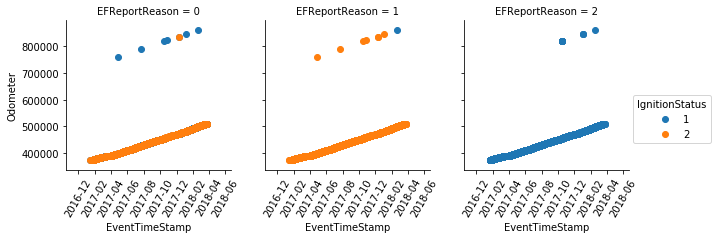

In [90]:
truck_1664 = df_event_level.loc[(df_event_level['EquipmentID'] == 1664)] 
fg = sns.FacetGrid(data=truck_1664, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

In [28]:
#truck_1713 = df_event_level.loc[(df_event_level['EquipmentID'] == 1713) & (df_event_level['IgnitionStatus'] == 1)] 
#truck_1713 = df_event_level.loc[(df_event_level['EquipmentID'] == 1713)] 

In [29]:
# descending fuel readings only #
#truck_1713_dec = truck_1713
#truck_1713_dec['fuel_delta'] = truck_1713_dec.TankLevelGallons - truck_1713_dec.TankLevelGallons.shift(1)
#truck_1713_dec['odometer_delta'] = truck_1713_dec.Odometer - truck_1713_dec.Odometer.shift(1)
#truck_1713_dec['mpg_change'] = truck_1713_dec.odometer_delta / truck_1713_dec.fuel_delta

#truck_1713_map = truck_1713_dec
#truck_1713_map = truck_1713_map[truck_1713_map['mpg_change'] < 0]
#plt.plot(truck_1713_map.Odometer, truck_1713_map.mpg_change, marker='.', linestyle='none')
#plt.show()

In [30]:
#truck_1713_map_wSpeed = truck_1713_map[truck_1713_map['Speed'] > 0]
#truck_1713_map_wSpeed = truck_1713_map_wSpeed.sort_values(by=['EventTimeStamp'])
#truck_1713_map_wSpeed['month_ts'] = pd.DatetimeIndex(truck_1713_map_wSpeed['EventTimeStamp']).month
#fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='IgnitionStatus', col='EFReportReason')
#fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

In [31]:
#fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='month_ts', col='EFReportReason')
#fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
#fg.set_xticklabels(rotation = 90);


In [32]:
#fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='EFReportReason', col='month_ts')
#fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
#fg.set_xticklabels(rotation = 60);


# Fuel by truck, miles by truck, fuel usage as a function of odometer change by truck

In [33]:
#df_fuel_trans
df_fuel_trans_fuels = df_fuel_trans[df_fuel_trans['TRNPI1'].isin(fuels)]
df_fuel_trans_fuels = df_fuel_trans_fuels.drop(columns=['TRNPI2','TRNPI3','TRNPI4','TRNPI5','TRNPI6','TRNPQ2','TRNPQ3','TRNPQ4','TRNPQ5','TRNPQ6'])

In [34]:
fuel_by_truck = df_fuel_trans_fuels.groupby(['TRNUNT','TRNPI1'], as_index=False)['TRNPQ1'].sum()
fuel_by_truck = fuel_by_truck[fuel_by_truck['TRNPQ1'] > 100]
fuel_by_truck['TRNUNT'] = fuel_by_truck['TRNUNT'].apply(str)

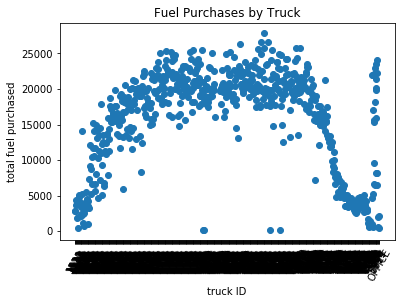

In [35]:
############### FUEL BY TRUCK SHOWN ###################
######### excluded trucks with < 100 gallons #########
#### NEED TO BRING IN ODOMETER CHANGE (Max - Min) ###
################## split by month? #################

_ = plt.scatter('TRNUNT','TRNPQ1',data=fuel_by_truck)
_ = plt.title('Fuel Purchases by Truck')
_ = plt.xlabel('truck ID')
_ = plt.ylabel('total fuel purchased')
_ = plt.xticks(rotation=60)
plt.show()

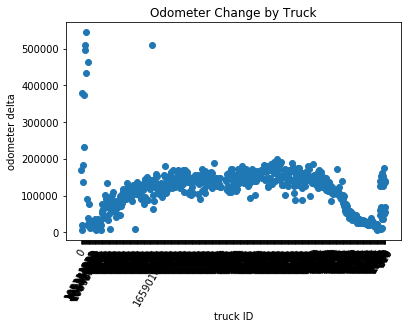

In [36]:
_ = plt.scatter('EquipmentID','odo_change',data=miles_by_truck)
_ = plt.title('Odometer Change by Truck')
_ = plt.xlabel('truck ID')
_ = plt.ylabel('odometer delta')
_ = plt.xticks(rotation=60)
plt.show();
# There should be no odometer changes > 180k miles during the time period shown

In [37]:
fuel_odo_use = pd.DataFrame()
fuel_odo_use = pd.merge(fuel_by_truck, miles_by_truck, how='left', left_on='TRNUNT', right_on='EquipmentID')
fuel_odo_use = pd.merge(fuel_odo_use, truck_events, how='left', left_on='EquipmentID', right_on='EquipmentID')
fuel_odo_use

,TRNUNT,TRNPI1,TRNPQ1,EquipmentID,min_odo,max_odo,median_odo,odo_change,Count
0,,ULSD,2887.02,NaN,NaN,NaN,NaN,NaN,NaN
1,1520,ULSD,2767.74,1520,511876.7,587759.8,579919.65,75883.1,1840.0
2,1521,ULSD,4406.22,1521,583918.2,612074.6,597780.80,28156.4,2597.0
3,1522,ULSD,3662.87,1522,206524.5,226182.2,216718.90,19657.7,2666.0
4,1523,ULSD,1909.91,1523,552332.1,563615.1,552350.90,11283.0,165.0
5,1524,ULSD,3912.98,1524,492407.9,517765.3,504675.30,25357.4,2387.0
6,1525,ULSD,427.13,NaN,NaN,NaN,NaN,NaN,NaN
7,1526,ULSD,1942.99,1526,576860.3,590814.4,583874.10,13954.1,1621.0
8,1527,ULSD,4736.10,1527,598520.9,629400.4,614790.30,30879.5,3309.0
9,1528,ULSD,5016.94,1528,587206.3,618110.9,602612.40,30904.6,3465.0


In [38]:
#print(fuel_by_truck[fuel_by_truck['TRNUNT'] == '1520'])
#print(miles_by_truck[miles_by_truck['EquipmentID'] == '1520'])

#print(fuel_by_truck['TRNUNT'].head(20))
#print(miles_by_truck['EquipmentID'].head(20))

#print(truck_events['EquipmentID'])

In [39]:
fuel_odo_use = fuel_odo_use.dropna(thresh=5)  #drop row if it has 5 nan values or more
#fuel_odo_use[fuel_odo_use['odo_change'] > 200000]

In [40]:
#odo_no_outliers = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.odo_change >200000)].index)
df_events_no_nan.reset_index()
odo_no_outliers = pd.DataFrame()
odo_no_outliers = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.Odometer == 0.0)].index)
#odo_no_outliers = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.odo_from_median_pct == 0.0)].index)
#odo_no_outliers = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.odo_from_median_pct < 0.3)].index)
#odo_no_outliers = df_events_no_nan.drop(df_events_no_nan[(df_events_no_nan.odo_from_median_pct > 1.5)].index)

#odo_no_outliers = df_events_no_nan[(df_events_no_nan.odo_from_median_pct > 0.45) & (df_events_no_nan.odo_from_median_pct < 1.5)]


In [41]:
odo_no_outliers['Odometer'].sort_values()

1637042        13.0
6530423        13.0
1637043        13.0
1637041        13.0
1637040        13.0
1637044        13.2
1637036        13.2
1637037        13.3
1651333        13.3
1637046        13.3
1651087        13.3
1651130        13.3
1651131        13.3
1651224        13.3
1651250        13.3
1648451        13.3
1651086        13.3
1651373        13.3
1648454        13.3
1650145        13.3
1650115        13.3
1652649        13.4
1652648        13.4
1652703        13.4
1652647        13.4
1652971        13.5
1653001        13.5
1653121        13.6
1653120        13.6
1657273        13.7
             ...   
7480946    637546.1
7480950    637546.1
7458906    637546.1
7480938    637546.1
7255057    637546.1
7255012    637546.1
7254789    637546.1
7480932    637546.1
7472722    637546.1
7480933    637546.1
7456392    637546.1
7456393    637546.1
7480934    637546.1
7461063    637546.1
7461064    637546.1
7458907    637546.1
7480935    637546.1
7457117    637546.1
7480926    637546.1


In [42]:
odo_no_outliers_backup = pd.DataFrame()
odo_no_outliers_backup['min_odo'] = odo_no_outliers.groupby(['EquipmentID'])['Odometer'].min()
odo_no_outliers_backup['max_odo'] = odo_no_outliers.groupby(['EquipmentID'])['Odometer'].max()
#odo_no_outliers['mean_odo'] = odo_no_outliers.groupby(['EquipmentID'])['Odometer'].mean()
#odo_no_outliers['median_odo'] = odo_no_outliers.groupby(['EquipmentID'])['Odometer'].median()
#odo_no_outliers['min_mean_variance'] = odo_no_outliers['max_odo']-odo_no_outliers['mean_odo']
#odo_no_outliers['max_mean_variance'] = odo_no_outliers['mean_odo']-odo_no_outliers['min_odo']
#odo_no_outliers['variance_of_variances'] = odo_no_outliers['max_mean_variance']-odo_no_outliers['min_mean_variance']
odo_no_outliers_backup['odo_change'] = (odo_no_outliers_backup['max_odo'] - odo_no_outliers_backup['min_odo'])
odo_no_outliers_backup = odo_no_outliers_backup.reset_index()
odo_no_outliers_backup = odo_no_outliers_backup[odo_no_outliers_backup['odo_change'] > 5000] 
#odo_no_outliers['EquipmentID'] = odo_no_outliers['EquipmentID'].apply(str)
#odo_no_outliers['EquipmentID'] = odo_no_outliers['EquipmentID'].str.strip()

In [43]:
#odo_no_outliers_backup = odo_no_outliers_backup[odo_no_outliers_backup['odo_change'] > 5000] 

In [44]:
odo_no_outliers_backup.head()

,EquipmentID,min_odo,max_odo,odo_change
0,0,7437.8,176789.4,169351.6
37,108034511,51290.9,89520.6,38229.7
43,1520,511876.7,587759.8,75883.1
44,1521,583918.2,612074.6,28156.4
45,1522,206524.5,226182.2,19657.7


In [45]:
fuel_odo_no_outliers = pd.DataFrame()
fuel_odo_no_outliers = pd.merge(fuel_by_truck, odo_no_outliers_backup, how='left', left_on='TRNUNT', right_on='EquipmentID')
#fuel_odo_use = pd.merge(fuel_odo_use, truck_events, how='left', left_on='EquipmentID', right_on='EquipmentID')
fuel_odo_no_outliers = pd.merge(fuel_odo_no_outliers, df_truck_info, how='left', left_on='TRNUNT', right_on='UNUNIT')
#fuel_odo_no_outliers.head()
fuel_odo_no_outliers.UNMAKE.value_counts()

KENWORTH    508
VOLVO       134
MACK         10
Name: UNMAKE, dtype: int64

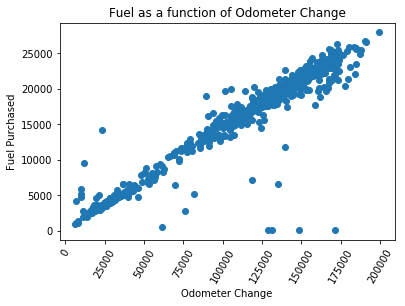

In [46]:
_ = plt.scatter('odo_change', 'TRNPQ1', data=fuel_odo_no_outliers)
_ = plt.xticks(rotation=60)
_ = plt.ylabel('Fuel Purchased')
_ = plt.xlabel('Odometer Change')
_ = plt.title('Fuel as a function of Odometer Change')
plt.show()

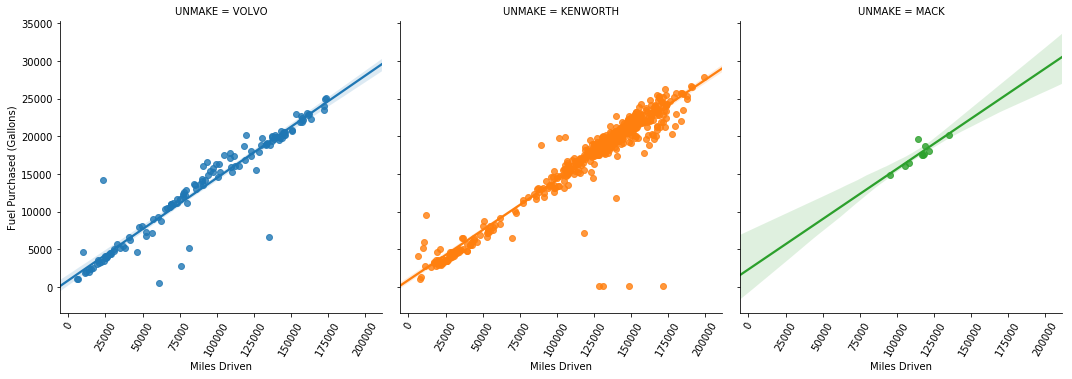

In [74]:
g = sns.lmplot(x='odo_change', y='TRNPQ1', data=fuel_odo_no_outliers, col='UNMAKE', hue='UNMAKE')
g = (g.set_axis_labels("Miles Driven", "Fuel Purchased (Gallons)"))
g = g.set_xticklabels(rotation=60)


In [48]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

output_file("fuel_by_truck.html")

source = ColumnDataSource(data=dict(
    x=fuel_odo_no_outliers.odo_change,
    y=fuel_odo_no_outliers.TRNPQ1,
    desc=fuel_odo_no_outliers.EquipmentID,
    make=fuel_odo_no_outliers.UNMAKE,
))

hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("EquipmentID", "@desc"),
    ("Make","@make")
])

p = figure(plot_width=950, plot_height=950, tools=[hover],
           title="Hover for Fuel Purchased by Truck")

p.circle('x', 'y', size=20, source=source)

show(p)

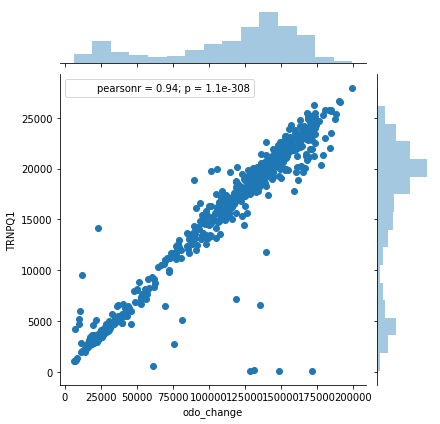

In [49]:
sns.jointplot(x='odo_change', y='TRNPQ1', data=fuel_odo_no_outliers);

In [88]:
#fuel_odo_no_outliers[fuel_odo_no_outliers['odo_change'] > 200000]

In [51]:
fuel_odo_use.to_csv('fuel_odo_use.csv')

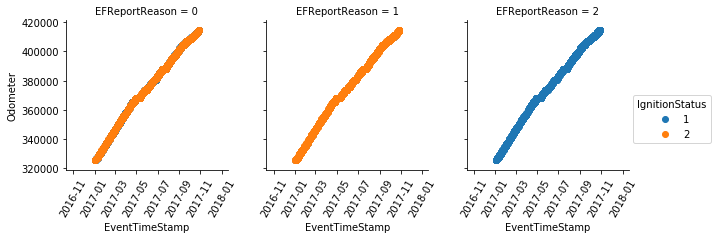

In [84]:
truck_1762 = df_events_no_nan.loc[(df_events_no_nan['EquipmentID'] == '1762')] 
fg = sns.FacetGrid(data=truck_1762, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

In [53]:
miles_by_1762 = miles_by_truck.loc[(miles_by_truck['EquipmentID'] == '1762')] 
fuel_by_1762 = fuel_by_truck.loc[(fuel_by_truck['TRNUNT'] == '1762')] 
mpg_1762 = ((miles_by_1762['odo_change'].iloc[0])/(fuel_by_1762.TRNPQ1.iloc[0]))
print("Truck 1762 averaged " + str(mpg_1762) + " miles per gallon")

Truck 1762 averaged 4.734624789011238 miles per gallon


In [54]:
detail_1762 = df_events[df_events['EquipmentID'] == '1762']
detail_1762['DriverID'].value_counts()

CASJE     5859
HOLD01    3961
Name: DriverID, dtype: int64

## Driver WAGL averaged 1.64mpg in truck 1534.

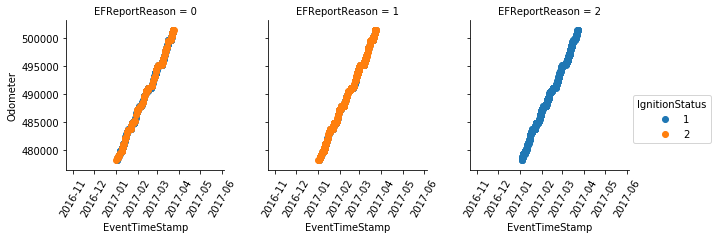

In [85]:
truck_1534 = df_events_no_nan.loc[(df_events_no_nan['EquipmentID'] == '1534')] 
fg = sns.FacetGrid(data=truck_1534, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

In [56]:
miles_by_1534 = miles_by_truck.loc[(miles_by_truck['EquipmentID'] == '1534')] 
fuel_by_1534 = fuel_by_truck.loc[(fuel_by_truck['TRNUNT'] == '1534')] 
mpg_1534 = ((miles_by_1534['odo_change'].iloc[0])/(fuel_by_1534.TRNPQ1.iloc[0]))
print("Truck 1534 averaged " + format(mpg_1534, '.2f') + " miles per gallon by purchasing " + format(fuel_by_1534.TRNPQ1.iloc[0],'.1f') + " gallons of fuel and driving " + format(miles_by_1534['odo_change'].iloc[0], '.1f') + " miles.")

Truck 1534 averaged 1.64 miles per gallon by purchasing 14154.9 gallons of fuel and driving 23259.3 miles.


In [57]:
detail_1534 = df_events[df_events['EquipmentID'] == '1534']
detail_1534['DriverID'].value_counts()

WAGL    3613
Name: DriverID, dtype: int64

### let's look at the other trucks driver WAGL drove......

In [58]:
detail_WAGL = df_events[df_events['DriverID'] == 'WAGL']
detail_WAGL['EquipmentID'].value_counts()

2034    12606
1534     3613
1526       51
Name: EquipmentID, dtype: int64

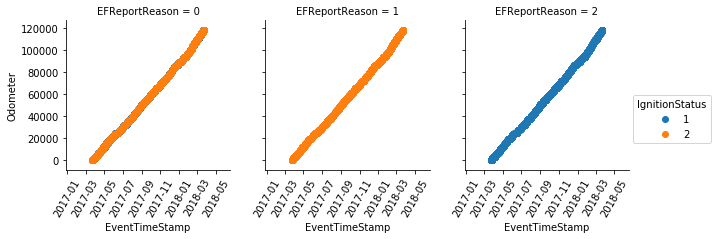

In [86]:
truck_2034 = df_events_no_nan.loc[(df_events_no_nan['EquipmentID'] == '2034')] 
fg = sns.FacetGrid(data=truck_2034, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

In [60]:
miles_by_2034 = miles_by_truck.loc[(miles_by_truck['EquipmentID'] == '2034')] 
fuel_by_2034 = fuel_by_truck.loc[(fuel_by_truck['TRNUNT'] == '2034')] 
mpg_2034 = ((miles_by_2034['odo_change'].iloc[0])/(fuel_by_2034.TRNPQ1.iloc[0]))
print("Truck 2034 averaged " + format(mpg_2034, '.2f') + " miles per gallon, driving " + format(miles_by_2034['odo_change'].iloc[0], '.1f') + " miles while purchasing " + format(fuel_by_2034.TRNPQ1.iloc[0], '.1f') + " gallons of fuel.")

Truck 2034 averaged 16.58 miles per gallon, driving 118482.3 miles while purchasing 7147.5 gallons of fuel.


## Driver WAGL averaged 16.57mpg in truck 2034, while averaging 1.64mpg in truck 1534.

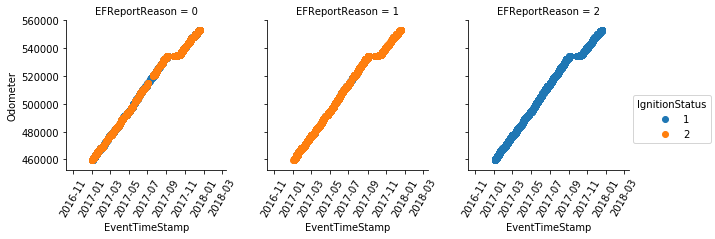

In [87]:
truck_1602 = df_events_no_nan.loc[(df_events_no_nan['EquipmentID'] == '1602')] 
fg = sns.FacetGrid(data=truck_1602, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

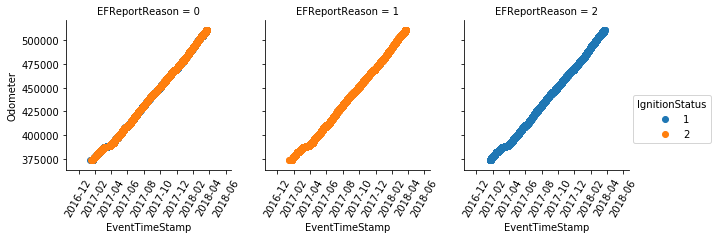

In [91]:
truck_1664 = df_events_no_nan.loc[(df_events_no_nan['EquipmentID'] == '1664')] 
fg = sns.FacetGrid(data=truck_1664, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation=60);

In [62]:
miles_by_1602 = miles_by_truck.loc[(miles_by_truck['EquipmentID'] == '1602')] 
fuel_by_1602 = fuel_by_truck.loc[(fuel_by_truck['TRNUNT'] == '1602')] 
mpg_1602 = ((miles_by_1602['odo_change'].iloc[0])/(fuel_by_1602.TRNPQ1.iloc[0]))
print("Truck 1602 averaged " + str(mpg_1602) + " miles per gallon")

Truck 1602 averaged 5.638187251762311 miles per gallon


In [63]:
detail_1602 = df_events[df_events['EquipmentID'] == '1602']
detail_1602['DriverID'].value_counts()

BROM01    13184
BYASH      2595
HERMI        42
HILB         19
Name: DriverID, dtype: int64

In [64]:
detail_BROM01 = df_events[df_events['DriverID'] == 'BROM01']
detail_BROM01['EquipmentID'].value_counts()

1602    13184
1643     1689
1591      296
1536       28
1745        8
Name: EquipmentID, dtype: int64

In [65]:
miles_by_1643 = miles_by_truck.loc[(miles_by_truck['EquipmentID'] == '1643')] 
fuel_by_1643 = fuel_by_truck.loc[(fuel_by_truck['TRNUNT'] == '1643')] 
mpg_1643 = ((miles_by_1643['odo_change'].iloc[0])/(fuel_by_1643.TRNPQ1.iloc[0]))
print("Truck 1643 averaged " + str(mpg_1643) + " miles per gallon")

Truck 1643 averaged 6.646469010147792 miles per gallon


In [66]:
detail_1643 = df_events[df_events['EquipmentID'] == '1643']
detail_1643['DriverID'].value_counts()

MANRI     7617
BROM01    1689
AUSGE     1647
HALDAV    1158
DUNE         6
SHOP3        2
Name: DriverID, dtype: int64

In [67]:
miles_by_1591 = miles_by_truck.loc[(miles_by_truck['EquipmentID'] == '1591')] 
fuel_by_1591 = fuel_by_truck.loc[(fuel_by_truck['TRNUNT'] == '1591')] 
mpg_1591 = ((miles_by_1591['odo_change'].iloc[0])/(fuel_by_1591.TRNPQ1.iloc[0]))
print("Truck 1591 averaged " + format(mpg_1591, '.2f') + " miles per gallon, driving " + format(miles_by_1591['odo_change'].iloc[0], '.1f') + " miles while purchasing " + format(fuel_by_1591.TRNPQ1.iloc[0], '.2f') + " gallons.")

Truck 1591 averaged 6.05 miles per gallon, driving 47916.4 miles while purchasing 7920.64 gallons.


In [68]:
detail_1591 = df_events[df_events['EquipmentID'] == '1591']
detail_1591['DriverID'].value_counts()

LIPG      3486
MAYMI     2063
WAKT      1290
RAMRI      598
WHIKEV     465
NASDE      322
BROM01     296
RUTJO      147
BAKM       125
SIMTIM      78
JEAJ        19
Name: DriverID, dtype: int64

In [69]:
df_fuel_trans

,TRNID,TRNDAT,TRNTIM,TRNTS#,TRNTSN,TRNSTC,TRNST,TRNDRI,TRNUNT,TRNPI1,...,TRNPI2,TRNPQ2,TRNPI3,TRNPQ3,TRNPI4,TRNPQ4,TRNPI5,TRNPQ5,TRNPI6,TRNPQ6
0,42574765,20170101,20,520277,FLYING J VANDALIA 97,VANDALIA,OH,ULAL,1564,SCLE,...,,0.00,,0.0,,0.0,,0.0,,0
1,42575331,20170101,48,516202,PILOT NEW BRAUNFELS 330,NEW BRAUNFELS,TX,MANRI,1584,ULSD,...,DEFD,7.71,CADV,1.0,,0.0,,0.0,,0
2,42578678,20170101,134,516277,PILOT 421,DALTON,GA,RUSR,1713,ULSD,...,DEFD,4.12,,0.0,,0.0,,0.0,,0
3,42578722,20170101,137,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,FOSJA,1711,ULSD,...,,0.00,,0.0,,0.0,,0.0,,0
4,42579695,20170101,302,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HICWIL,1837,ULSD,...,,0.00,,0.0,,0.0,,0.0,,0
5,42579752,20170101,307,519125,PILOT #575,ST MARYS,GA,BATK,1992,ULSD,...,,0.00,,0.0,,0.0,,0.0,,0
6,42579836,20170101,315,519125,PILOT #575,ST MARYS,GA,BATK,1992,SCLE,...,,0.00,,0.0,,0.0,,0.0,,0
7,42580765,20170101,430,516304,PILOT GAFFNEY 453,GAFFNEY,SC,MARJOH,1730,ULSD,...,DEFD,5.50,,0.0,,0.0,,0.0,,0
8,42580767,20170101,430,516156,PILOT CHARLOTTE 275,CHARLOTTE,NC,JAML,1672,ULSD,...,,0.00,,0.0,,0.0,,0.0,,0
9,42580868,20170101,437,516156,PILOT CHARLOTTE 275,CHARLOTTE,NC,JAML,1672,CADV,...,,0.00,,0.0,,0.0,,0.0,,0


In [70]:
df_fuel_trans['TRNDRI'] = df_fuel_trans['TRNDRI'].str.strip()
WAGL_trans = df_fuel_trans[df_fuel_trans['TRNDRI'] == 'WAGL']

In [71]:
WAGL_trans.TRNUNT.value_counts()

1534    275
2034     89
Name: TRNUNT, dtype: int64

In [72]:
detail_WAGL = df_events[df_events['DriverID'] == 'WAGL']
detail_WAGL['EquipmentID'].value_counts()

2034    12606
1534     3613
1526       51
Name: EquipmentID, dtype: int64

## 12,606 events on Truck 2034 but only 89 fuel trans.  3,613 events on 1534, but 275 fuel trans

In [73]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 191.96102094650269 seconds ---
